In [1]:
# Regular packages
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore") # might not be the best idea

In [2]:
# pyspark packages 
from pyspark.sql.functions import col, concat, collect_list,struct
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.functions import udf, array, array_distinct, array_min,array_max,array_union, explode
from pyspark.sql.types import IntegerType, DoubleType, ArrayType

from pyspark import SparkContext
from pyspark.sql import Row

## Analysis of RDD 

In [3]:
def file_to_rdd(file):
    """
    This function takes a file name and converts it into an RDD.
    
    Arguments:
    file (str): file name
    
    Returns:
    An RDD containing all information extracted from the file.
    """

    if file[-3:] == "csv" : 
        data = spark.read.format("csv").option("inferSchema", "true")\
                                        .option("delimiter", ',')\
                                        .option("header", 'true')\
                                        .load(file).cache()

        rdd = adj_cache.rdd.map(tuple)
        return rdd
    elif file[-3:] == "txt" : 
        rdd_web = sc.textFile(file) \
                    .map(lambda line: line.split('\t')) \
                    .filter(lambda line: len(line)>1) \
                        .map(lambda line: (line[0],line[1]))

        return rdd_web

In [4]:
sc = SparkContext()

In [5]:
spark = SparkSession.builder.appName('abc').getOrCreate()

In [6]:
#First try with the example of the research paper 

from pyspark import SparkContext

time1 = time.time()

graph = sc.parallelize([(0, 1), (1, 2), (1, 3), (3, 4), (5, 6), (6, 7)])
counter_new_pair = sc.accumulator(1)

def reducer(node):
    minimum = node[0]
    value_List = []
    joined = []
  
    for value in node[1]:
        if value<minimum:
            minimum = value
        value_List.append(value)
    if minimum<node[0]:
        joined.append((node[0],minimum))
        for value in value_List:
            if minimum != value:
                counter_new_pair.add(1)
                joined.append((value, minimum))
    return joined

while counter_new_pair.value > 0:
    counter_new_pair = sc.accumulator(0)

    #CCF-Iterate
    mapping_1 = graph.map(lambda node : (node[0], node[1]))
    mapping_2 = graph.map(lambda node : (node[1], node[0]))
    fusion = mapping_1.union(mapping_2)
    fusion = fusion.groupByKey().map(lambda node : (node[0], list(node[1])))
    joined = fusion.flatMap(lambda node: reducer(node))
    # CCF-Dedup
    graph = joined.map(lambda node : ((node[0], node[1]), None)).groupByKey()
    graph = graph.map(lambda x: (x[0][0], x[0][1]))
    graph.collect()
  
    print("counter: ", counter_new_pair)
  
    graph.collect()
    
time2 = time.time()

print("It took {:.3f} seconds".format(time2-time1))

counter:  4
counter:  9
counter:  4
counter:  0
It took 7.171 seconds


In [7]:
#Let's try with the Google Graph 

web_google = sc.textFile("web-Google 2.txt")\
                    .map(lambda line: line.split('\t')) \
                    .filter(lambda line: len(line)>1) \
                        .map(lambda line: (line[0],line[1]))

graph = web_google

time1 = time.time()

counter_new_pair = sc.accumulator(1)

def reducer(node):
    minimum = node[0]
    value_List = []
    joined = []
  
    for value in node[1]:
        if value<minimum:
            minimum = value
        value_List.append(value)
    if minimum<node[0]:
        joined.append((node[0],minimum))
        for value in value_List:
            if minimum != value:
                counter_new_pair.add(1)
                joined.append((value, minimum))
    return joined

while counter_new_pair.value > 0:
    counter_new_pair = sc.accumulator(0)

    #CCF-Iterate
    mapping_1 = graph.map(lambda node : (node[0], node[1]))
    mapping_2 = graph.map(lambda node : (node[1], node[0]))
    fusion = mapping_1.union(mapping_2)
    fusion = fusion.groupByKey().map(lambda node : (node[0], list(node[1])))
    joined = fusion.flatMap(lambda node: reducer(node))
    # CCF-Dedup
    graph = joined.map(lambda node : ((node[0], node[1]), None)).groupByKey()
    graph = graph.map(lambda x: (x[0][0], x[0][1]))
    graph.collect()
  
    print("counter: ", counter_new_pair)
    
time2 = time.time()

print("It took {:.3f} seconds".format(time2-time1))

counter:  8546673
counter:  4774134
counter:  3235857
counter:  3852842
counter:  2014247
counter:  94614
counter:  1548
counter:  0
It took 214.230 seconds


In [8]:
# Comparison according to graph size 

values = [len(web_google.collect())//(10-i) for i in range(1, 10)]

time_ = []

for i in range(len(values)):
    graph = sc.parallelize(web_google.collect()[1:values[i]])
    
    time1 = time.time()
    
    counter_new_pair = sc.accumulator(1)
    
    while counter_new_pair.value > 0:
        
        counter_new_pair = sc.accumulator(0)

        #CCF-Iterate
        mapping_1 = graph.map(lambda node : (node[0], node[1]))
        mapping_2 = graph.map(lambda node : (node[1], node[0]))
        fusion = mapping_1.union(mapping_2)
        fusion = fusion.groupByKey().map(lambda node : (node[0], list(node[1])))
        joined = fusion.flatMap(lambda node: reducer(node))
        # CCF-Dedup
        graph = joined.map(lambda node : ((node[0], node[1]), None)).groupByKey()
        graph = graph.map(lambda x: (x[0][0], x[0][1]))
        graph.collect()

    time2 = time.time()
    
    time_.append((i, time2-time1))

In [9]:
time_

[(0, 91.5123999118805),
 (1, 91.60296392440796),
 (2, 96.65851593017578),
 (3, 106.07743406295776),
 (4, 97.26055073738098),
 (5, 98.16124200820923),
 (6, 109.27431011199951),
 (7, 128.5003592967987),
 (8, 1556.156954050064)]

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Speed (in seconds) relatively to the % of the graph taken")
plt.plot([time_[i][1] for i in range(len(time_))]);

## Try part, Dataframe

In [10]:
df = spark.read.format("csv").option("inferSchema", "true")\
                                        .option("delimiter", ',')\
                                        .option("header", 'true')\
                                        .load("web-Google_500000.csv").toDF("val","key").cache()

In [11]:
df.show()

+------+------+
|   val|   key|
+------+------+
|     0|867923|
|     0|891835|
| 11342|     0|
| 11342| 27469|
| 11342| 38716|
| 11342|309564|
| 11342|322178|
| 11342|387543|
| 11342|427436|
| 11342|538214|
| 11342|638706|
| 11342|645018|
| 11342|835220|
| 11342|856657|
| 11342|867923|
| 11342|891835|
|824020|     0|
|824020| 91807|
|824020|322178|
|824020|387543|
+------+------+
only showing top 20 rows



In [12]:
import pyspark
from pyspark.sql import Window
from pyspark.sql.functions import *

def ccf_iterate_map_df(df):
    newRow = df.select("val", "key")
    df1 = df.union(newRow)
    return df1

def ccf_iterate_reduce_df(df1):
    window = Window.orderBy("key","val").partitionBy("key")
    df_min = df1.withColumn("min", min("val").over(window))

    new_column_1 = expr( """IF(min > key, Null, IF(min = val, key, val))""")
    new_column_2 = expr("""IF(min > key, Null, min)""")
    new_df = (df_min
      .withColumn("new_key", new_column_1)
      .withColumn("new_val", new_column_2)) \
    .na.drop() \
    .select(col("new_key").alias("key"), col("new_val").alias("val")) \
    .sort("val", "key") 
        
    df2 = new_df.distinct()
    
    return df2, df_min


import time

begin = time.time()
counter = sc.accumulator(1)
iteration = 0
while counter!=0:
    counter = sc.accumulator(1)
    iteration +=1
    df1 = ccf_iterate_map_df(df)
    df.unpersist()
    df, df_counter = ccf_iterate_reduce_df(df1)
    df1.unpersist()
    df_counter = df_counter.withColumn("counter_col", expr("""IF(min > key, 0, IF(min = val, 0, 1))"""))
    counter = sc.accumulator(df_counter.select(sum("counter_col")).collect()[0][0])
    print(counter)
    
end = time.time()

645720
188263
249888
326246
252536
73441
518
0
0


KeyboardInterrupt: 

In [ ]:
print(end-begin)

In [6]:
def file_to_df(file):
    """
    This function takes a file name and converts it into a DataFrame.
    
    Arguments:
    file (str): file name
    
    Returns:
    An DataFrame containing all information extracted from the file.
    """
    
    if file[-3:] == "csv" : 
        data = spark.read.format("csv").option("inferSchema", "true")\
                                        .option("delimiter", ',')\
                                        .option("header", 'true')\
                                        .load(file).toDF("To","From").cache()

        return adj_cache
    elif file[-3:] == "txt" : 
        df_web = sc.textFile(file) \
            .map(lambda line: (line.split('\t'))).toDF()\
            .select(col('_1').cast(IntegerType()).alias('To'), col('_2').cast(IntegerType()).alias('From'))

        #Remove header if there
        #df_web = df_web.filter(df_web.To !='FromNodeId' )

        return df_web

In [7]:
names = ["web-Google_500000.csv", "web-Google_1000000.csv", "web-Google_1500000.csv", "web-Google_2000000.csv", "web-Google_2500000.csv", "web-Google_3000000.csv", "web-Google_3500000.csv", "web-Google_4000000.csv", "web-Google_total.csv"]

def get_groups_df(df):
    """
    This function extracts connected components from a DataFrame, and assigns
    the smallest component value of each group as the group name. 
    
    Arguments:
    df (df): DataFrame name
    
    Returns:
    t (float) : Computational Time
    size (int) : Total number of distinct edges in the input graph
    num_of_groups (int) : Number of groups of connected components
    df (DataFrame) : An DataFrame containing as many tuples as the number of unique components in 
    the original DataFrame: the key is the component and the value is the group name.
    """
    
    #Count of edges 
    reverseDF = df.select(col("From").alias("To"),col("To").alias("From")) # getting all (v,k)
    df_0 = df.union(reverseDF)# Building a new DataFrame containing all (k,v) and (v,k)
    size = df_0.distinct().count()/2
    
    # Final number of tuples must be equal to the number of distinct values in our original RDD
    # And we can prove that they are equal only once the solution is found 
    t = time.time()
    
    #Counter measures the max distance between two neighboors of the group 
    counter = 0 
    while df.count()!= df.select('To').distinct().count() :
        counter +=1 
        df = CCF_DEDUP_df(df) # function explained above 
    t = time.time() - t
    
    #Getting the number of groups of connected components
    num_of_groups = len(df.select('From').distinct().collect())
    
    return t, size,num_of_groups, counter,  df

In [8]:
def our_union (x):
    x[1].append(x[0])
    return x[1]

our_union_udf = f.udf(our_union, ArrayType(IntegerType()))
findmin = f.udf(lambda x: min(x), IntegerType())
our_distinct = f.udf(lambda x: list(set(x)), ArrayType(IntegerType()))

def CCF_DEDUP_df(df):
    """
    This function takes an DataFrame and returns for each component the closest
    connected neighbor, in one way or the other: we can have (a,b) or (b,a), or both.
    It is inspired from the CCF_iterate and and the CCF_Dedup found 
    in the article https://www.cse.unr.edu/~hkardes/pdfs/ccf.pdf
    
    Arguments:
    df (df): DataFrame name
    
    Returns:
    An DataFrame containing for each component the closest connected 
    neighbor(direct relationship only),in one way or the other. 
    """

    # Our goal is to list all existing edges in both ways: (k,v) and (v,k)
    # Our called RDD contains all (k,v) and we want to add all (v,k)
    reverseDF = df.select(col("From").alias("To"),col("To").alias("From"))# getting all (v,k)
    df_0 = df.union(reverseDF)# Building a new DataFrame containing all (k,v) and (v,k)
    
    # Grouping by key on the first element (k, [v1, v2...])
    df_1 = df_0.groupBy(col("To")).agg(our_distinct(collect_list(col("From"))).alias('From'))
    
    # New k: the minimum between k and all elements included in v 
    # New v: all values from k and v
    #df_2 = df_1.withColumn('From', array_union(df_1.From, array(df_1.To))).withColumn('To', findmin("From"))
    df_2 = df_1.withColumn('From', our_union_udf(struct(df_1.To, df_1.From)))\
                    .withColumn('To', findmin("From"))\
                        .withColumn('From', our_distinct('From'))
    
    # Extracting each element of v as our key k and assigning it the corresponding minimum found above
    df_3 = df_2.select( explode(col("From")).alias("To"), col("To").alias("From")).dropDuplicates()
    
    return df_3

In [26]:
#Create DataFrame to store size of graph, and computation time
res_DF = pd.DataFrame(index=["Number of Edges",'Number of connected components',"#of indirect neighboors", "Computational time (RDD)"])

for file in names:
    rdd = spark.read.format("csv").option("inferSchema", "true")\
                                        .option("delimiter", ',')\
                                        .option("header", 'true')\
                                        .load(file).toDF("To","From").cache()
    
    t, size, num_of_groups,counter,  df = get_groups_df(rdd)
    res_DF.loc[:, file] = (round(size), round(num_of_groups),counter,  round(t,3))
res_DF = res_DF.sort_values('Num of Edges',axis=1)
res_DF

Py4JJavaError: An error occurred while calling o7826.count.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 6 in stage 2006.0 failed 1 times, most recent failure: Lost task 6.0 in stage 2006.0 (TID 347846) (hippolytes-macbook-pro.home executor driver): java.lang.OutOfMemoryError: GC overhead limit exceeded
	at scala.collection.mutable.ArrayBuilder$.make(ArrayBuilder.scala:50)
	at scala.Array$$anon$2.apply(Array.scala:66)
	at scala.Array$$anon$2.apply(Array.scala:65)
	at scala.collection.TraversableLike.collect(TraversableLike.scala:358)
	at scala.collection.TraversableLike.collect$(TraversableLike.scala:357)
	at scala.collection.mutable.ArrayOps$ofRef.collect(ArrayOps.scala:198)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.initAggregationBuffer(ObjectAggregationIterator.scala:119)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.createNewAggregationBuffer(ObjectAggregationIterator.scala:111)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.$anonfun$processInputs$2(ObjectAggregationIterator.scala:185)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator$$Lambda$4097/1645488900.apply(Unknown Source)
	at org.apache.spark.sql.execution.aggregate.SortBasedAggregator$$anon$1.findNextSortedGroup(ObjectAggregationIterator.scala:260)
	at org.apache.spark.sql.execution.aggregate.SortBasedAggregator$$anon$1.hasNext(ObjectAggregationIterator.scala:246)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.hasNext(ObjectAggregationIterator.scala:80)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:155)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.executor.Executor$TaskRunner$$Lambda$1295/750976503.apply(Unknown Source)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2202)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2201)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1078)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2440)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2382)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2371)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2202)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2223)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2242)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2267)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:390)
	at org.apache.spark.sql.Dataset.$anonfun$count$1(Dataset.scala:3006)
	at org.apache.spark.sql.Dataset.$anonfun$count$1$adapted(Dataset.scala:3005)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3687)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:772)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3685)
	at org.apache.spark.sql.Dataset.count(Dataset.scala:3005)
	at sun.reflect.GeneratedMethodAccessor154.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.OutOfMemoryError: GC overhead limit exceeded
	at scala.collection.mutable.ArrayBuilder$.make(ArrayBuilder.scala:50)
	at scala.Array$$anon$2.apply(Array.scala:66)
	at scala.Array$$anon$2.apply(Array.scala:65)
	at scala.collection.TraversableLike.collect(TraversableLike.scala:358)
	at scala.collection.TraversableLike.collect$(TraversableLike.scala:357)
	at scala.collection.mutable.ArrayOps$ofRef.collect(ArrayOps.scala:198)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.initAggregationBuffer(ObjectAggregationIterator.scala:119)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.createNewAggregationBuffer(ObjectAggregationIterator.scala:111)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.$anonfun$processInputs$2(ObjectAggregationIterator.scala:185)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator$$Lambda$4097/1645488900.apply(Unknown Source)
	at org.apache.spark.sql.execution.aggregate.SortBasedAggregator$$anon$1.findNextSortedGroup(ObjectAggregationIterator.scala:260)
	at org.apache.spark.sql.execution.aggregate.SortBasedAggregator$$anon$1.hasNext(ObjectAggregationIterator.scala:246)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.hasNext(ObjectAggregationIterator.scala:80)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:155)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.executor.Executor$TaskRunner$$Lambda$1295/750976503.apply(Unknown Source)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 55070)
Traceback (most recent call last):
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/socketserver.py", line 720, in __init__
    self.handle()
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/pyspark/accumulators.py", line 262, in handle
    poll(accum_updates)
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/pyspark/accumulators.py", line 23

In [12]:
#Create DataFrame to store size of graph, and computation time
names = ["web-Google_500000.csv", "web-Google_1000000.csv", "web-Google_1500000.csv", "web-Google_2000000.csv", "web-Google_2500000.csv", "web-Google_3000000.csv", "web-Google_3500000.csv", "web-Google_4000000.csv", "web-Google_total.csv"]

res_RDD = pd.DataFrame(index=["Number of Edges",'Number of connected components',"#of indirect neighboors", "Computational time (RDD)"])

for file in names:
    rdd = sc.textFile(file)\
                    .map(lambda line: line.split(',')) \
                    .filter(lambda line: len(line)>1) \
                        .map(lambda line: (line[0],line[1]))
    
    t, size, num_of_groups,counter,  df = get_groups_rdd(rdd)
    res_RDD.loc[:, file] = (round(size), round(num_of_groups),counter,  round(t,3))
res_RDD = res_RDD.sort_values('Number of Edges',axis=1)
res_RDD

,web-Google_500000.csv,web-Google_1000000.csv,web-Google_1500000.csv,web-Google_2000000.csv,web-Google_2500000.csv,web-Google_3000000.csv,web-Google_3500000.csv,web-Google_4000000.csv,web-Google_total.csv
Number of Edges,401423.000,797810.000,1190931.00,1590942.000,1995511.000,2414404.000,2843914.000,3288014.000,4322051.000
Number of connected components,1383.000,2287.000,3022.00,3613.000,4118.000,4276.000,4261.000,4052.000,2746.000
#of indirect neighboors,7.000,7.000,7.00,7.000,7.000,7.000,7.000,7.000,7.000
Computational time (RDD),61.235,81.538,108.53,119.027,149.105,160.336,187.692,215.346,312.024


In [13]:
res_RDD.to_csv("RDD.csv")

In [ ]:
res

In [10]:
def CCF_DEDUP_rdd(rdd):
    """
    This function takes an RDD and returns for each component the closest
    connected neighbor, in one way or the other: we can have (a,b) or (b,a), or both.
    It is inspired from the CCF_iterate and and the CCF_Dedup found 
    in the article https://www.cse.unr.edu/~hkardes/pdfs/ccf.pdf
    
    Arguments:
    rdd (rdd): rdd name
    
    Returns:
    An RDD containing for each component the closest connected 
    neighbor(direct relationship only),in one way or the other. 
    """
    
    # Our goal is to list all existing edges in both ways: (k,v) and (v,k)
    # Our called RDD contains all (k,v) and we want to add all (v,k)
    
    rdd_reverse = rdd.map(lambda x :(x[1], x[0])) # getting all (v,k)
    rdd_0 = rdd.union(rdd_reverse) # Building a new RDD containing all (k,v) and (v,k)
    
    # Grouping by key on the first element (k, [v1, v2...])
    rdd_1 = rdd_0.groupByKey().map(lambda x : (x[0], list(x[1])))
    
    # New k: the minimum between k and all elements included in v 
    # New v: all values from k and v
    rdd_2 = rdd_1.map(lambda x : (min(x[0], min(x[1])),  list(set(x[1] + [x[0]]))))
    
    # Extracting each element of v as our key k and assigning it the corresponding minimum found above
    rdd_3 = rdd_2.flatMapValues(lambda x : x).map(lambda x : (x[1], x[0])).distinct()
    
    return rdd_3

In [17]:
sc.textFile("web-Google_1000000.csv")\
                    .map(lambda line: line.split(',')) \
                    .filter(lambda line: len(line)>1) \
                        .map(lambda line: (line[0],line[1])).collect()

[('0', '824020'),
 ('0', '867923'),
 ('0', '891835'),
 ('11342', '0'),
 ('11342', '27469'),
 ('11342', '38716'),
 ('11342', '309564'),
 ('11342', '322178'),
 ('11342', '387543'),
 ('11342', '427436'),
 ('11342', '538214'),
 ('11342', '638706'),
 ('11342', '645018'),
 ('11342', '835220'),
 ('11342', '856657'),
 ('11342', '867923'),
 ('11342', '891835'),
 ('824020', '0'),
 ('824020', '91807'),
 ('824020', '322178'),
 ('824020', '387543'),
 ('824020', '417728'),
 ('824020', '438493'),
 ('824020', '500627'),
 ('824020', '535748'),
 ('824020', '695578'),
 ('824020', '867923'),
 ('824020', '891835'),
 ('867923', '0'),
 ('867923', '11342'),
 ('867923', '136593'),
 ('867923', '414038'),
 ('867923', '500627'),
 ('867923', '523684'),
 ('867923', '760842'),
 ('867923', '815602'),
 ('867923', '835220'),
 ('867923', '846213'),
 ('867923', '857527'),
 ('867923', '891835'),
 ('891835', '0'),
 ('891835', '11342'),
 ('891835', '112028'),
 ('891835', '235849'),
 ('891835', '302284'),
 ('891835', '417728

In [11]:
def get_groups_rdd(rdd):
    """
    This function extracts connected components from an RDD, and assigns
    the smallest component value of each group as the group name. 
    
    Arguments:
    rdd (rdd): rdd name
    
    Returns:
    t (float) : Computational Time
    size (int) : Total number of distinct edges in the input graph
    num_of_groups (int) : Number of groups of connected components
    rdd (rdd) : An RDD containing as many tuples as the number of unique components in 
    the original RDD: the key is the component and the value is the group name.
    """
    
    #Count of edges 
    rdd_reverse = rdd.map(lambda x :(x[1], x[0])) # getting all (v,k)
    rdd_0 = rdd.union(rdd_reverse) # Building a new RDD containing all (k,v) and (v,k)
    size = (rdd_0.distinct()).count()/2
    
    # Final number of tuples must be equal to the number of distinct values in our original RDD
    # And we can prove that they are equal only once the solution is found 
    t = time.time()
    
    #The counter counts the number of times the algorithm goes through the loop
    #It will depend on the maximum distance between two components of the same group
    counter = 0
    while rdd.count()!= (rdd.groupBy(lambda x : x[0]).distinct()).count() :
        counter +=1
        rdd = CCF_DEDUP_rdd(rdd) # function explained above 
    t = time.time() - t
       
    #Getting the number of groups of connected components
    num_of_groups = len(rdd.values().distinct().collect())
    
    return t, size, num_of_groups, counter, rdd

In [29]:
res_DF.to_csv("Resultat_DF.csv")

In [ ]:
names = ["web-Google_500000.csv", "web-Google_1000000.csv", "web-Google_1500000.csv", "web-Google_2000000.csv", "web-Google_2500000.csv", "web-Google_3000000.csv", "web-Google_3500000.csv", "web-Google_4000000.csv", "web-Google_total.csv"]

liste = []
for i in names:
    df = spark.read.format("csv").option("inferSchema", "true")\
                                        .option("delimiter", ',')\
                                        .option("header", 'true')\
                                        .load(i).toDF("val","key").cache()
    begin = time.time()
    counter = 1
    iteration = 0
    while counter!=0:
        iteration +=1
        df1 = ccf_iterate_map_df(df)
        df, df_counter = ccf_iterate_reduce_df(df1)
        df_counter = df_counter.withColumn("counter_col", expr("""IF(min > key, 0, IF(min = val, 0, 1))"""))
        counter = df_counter.select(sum("counter_col")).collect()[0][0]
        print(counter)
    
    end = time.time()
    print((i, end-begin))
    liste.append((i, end-begin))

645720
188263
249888
326246
252536
73441
518
0
('web-Google_500000.csv', 596.3252799510956)
1379336
411275
466760
634325
483907
133761
1344
0
('web-Google_1000000.csv', 572.8978681564331)
2158798
651571
663595
916646
680213
154277
1966
0
('web-Google_1500000.csv', 967.4510378837585)
2965172
912104
846662
1189233
876542
174605
2038
0
('web-Google_2000000.csv', 597.5754508972168)
3789920
1184366
1023125
1451456
1057318
205858
2436
0
('web-Google_2500000.csv', 3045.270040988922)
4630528
1479228
1199555
1712234
1248788
214513
3162
0
('web-Google_3000000.csv', 622.9565620422363)
5483928
1785818
1373705
1981569
1446347


## Analysis of Dataframes

In [13]:
#First, let's define our function to import and analyze Dataframes

def our_union (x):
    x[1].append(x[0])
    return x[1]

our_union_udf = f.udf(our_union, ArrayType(IntegerType()))
findmin = f.udf(lambda x: min(x), IntegerType())
our_distinct = f.udf(lambda x: list(set(x)), ArrayType(IntegerType()))

def CCF_DEDUP_df(df):
    
    reverseDF = df.select(col("From").alias("To"),col("To").alias("From"))
    df_0 = df.union(reverseDF)
    
    df_1 = df_0.groupBy(col("To")).agg(our_distinct(collect_list(col("From"))).alias('From'))
    df_2 = df_1.withColumn('From', our_union_udf(struct(df_1.To, df_1.From)))\
                    .withColumn('To', findmin("From"))\
                        .withColumn('From', our_distinct('From'))
    
    df_3 = df_2.select( explode(col("From")).alias("To"), col("To").alias("From")).dropDuplicates()
    
    return df_3

def Analyze(df):
    
    reverseDF = df.select(col("From").alias("To"),col("To").alias("From"))
    df_0 = df.union(reverseDF)
      
    size = df_0.distinct().count()/2

    t = time.time()
    
    counter = sc.accumulator(0)
    while df.count()!= df.select('To').distinct().count() :
        counter.add(1)
        df = CCF_DEDUP_df(df) 
    t = time.time() - t
    
    #Getting the number of groups of connected components
    num_of_groups = len(df.select('From').distinct().collect())
    
    return t, size,num_of_groups, counter,  df

In [18]:
df = spark.read.format("csv").option("inferSchema", "true")\
                                        .option("delimiter", ',')\
                                        .option("header", 'true')\
                                        .load("web-Google_total.csv").toDF("From","To").cache()

In [19]:
Analyze(df)

PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 604, in main
    process()
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 596, in process
    serializer.dump_stream(out_iter, outfile)
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 211, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 132, in dump_stream
    for obj in iterator:
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 200, in _batched
    for item in iterator:
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 450, in mapper
    result = tuple(f(*[a[o] for o in arg_offsets]) for (arg_offsets, f) in udfs)
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 450, in <genexpr>
    result = tuple(f(*[a[o] for o in arg_offsets]) for (arg_offsets, f) in udfs)
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 85, in <lambda>
    return lambda *a: f(*a)
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 73, in wrapper
    return f(*args, **kwargs)
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 77, in <lambda>
    return lambda *a: g(f(*a))
  File "<ipython-input-13-8bc29344e622>", line 8, in <lambda>
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/functions.py", line 168, in min
    return _invoke_function_over_column("min", col)
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/functions.py", line 66, in _invoke_function_over_column
    return _invoke_function(name, _to_java_column(col))
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/column.py", line 45, in _to_java_column
    raise TypeError(
TypeError: Invalid argument, not a string or column: [914056, 102669, 80527, 29338, 759848, 593321, 109485, 801074, 911165, 382911, 906432, 683587, 17093, 265669, 809163, 224718, 357073, 909528, 105956, 302564, 302064, 702328, 622842, 43515, 444796, 85] of type <class 'list'>. For column literals, use 'lit', 'array', 'struct' or 'create_map' function.


In [20]:
df.show()

+------+------+
|  From|    To|
+------+------+
|     0|867923|
|     0|891835|
| 11342|     0|
| 11342| 27469|
| 11342| 38716|
| 11342|309564|
| 11342|322178|
| 11342|387543|
| 11342|427436|
| 11342|538214|
| 11342|638706|
| 11342|645018|
| 11342|835220|
| 11342|856657|
| 11342|867923|
| 11342|891835|
|824020|     0|
|824020| 91807|
|824020|322178|
|824020|387543|
+------+------+
only showing top 20 rows



## RDD vs Dataframe

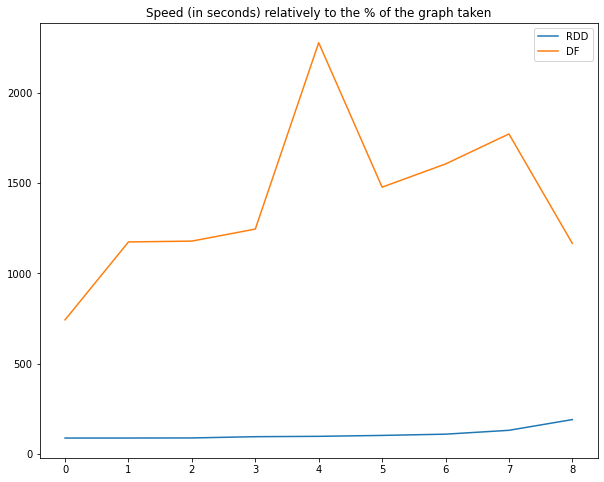

In [22]:
plt.figure(figsize=(10, 8))
plt.title("Speed (in seconds) relatively to the % of the graph taken")
plt.plot([time_[i][1] for i in range(len(time_))], label="RDD")
plt.plot([time_df[i] for i in range(len(time_df))], label="DF")
plt.legend()
plt.show();